<a href="https://colab.research.google.com/github/imnaimur/cse427_ML/blob/main/CSE428_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path in your Google Drive where you want to save the model
MODEL_SAVE_PATH = "/content/drive/MyDrive/BRISC2025_Project/best_unet_model.pth"
CHECKPOINT_PATH = "/content/drive/MyDrive/BRISC2025_Project/latest_checkpoint.pth"
RESULTS_SAVE_PATH = "/content/drive/MyDrive/BRISC2025_Project/training_results.pth"

In [ ]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.amp import autocast
show = False
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support

In [ ]:
# Install the required library for image augmentations
!pip install albumentations
!pip install -q scikit-learn seaborn

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("briscdataset/brisc2025")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brisc2025


## Load the data

Load the dataset into a pandas DataFrame.


In [ ]:
import os

segmentation_train_path = path + "/brisc2025/segmentation_task/train"
if os.path.exists(segmentation_train_path):
    print("Contents of segmentation_task/train directory:", os.listdir(segmentation_train_path))

train_image_dir = path + "/brisc2025/segmentation_task/train/images"
train_mask_dir = path + "/brisc2025/segmentation_task/train/masks"

if os.path.exists(train_image_dir) and os.path.exists(train_mask_dir):
    print("Contents of train directory:", os.listdir(train_image_dir))


segmentation_test_path = path + "/brisc2025/segmentation_task/test"
if os.path.exists(segmentation_test_path):
    print("Contents of segmentation_task/test directory:", os.listdir(segmentation_test_path))

test_image_dir = path + "/brisc2025/segmentation_task/test/images"
test_mask_dir = path + "/brisc2025/segmentation_task/test/masks"

if os.path.exists(test_image_dir) and os.path.exists(test_mask_dir):
    print("Contents of test directory:", os.listdir(test_image_dir))


Contents of segmentation_task/train directory: ['images', 'masks']
Contents of train directory: ['brisc2025_train_04966_pi_sa_t1.jpg', 'brisc2025_train_01914_me_co_t1.jpg', 'brisc2025_train_00160_gl_ax_t1.jpg', 'brisc2025_train_03927_pi_ax_t1.jpg', 'brisc2025_train_03781_pi_ax_t1.jpg', 'brisc2025_train_00395_gl_co_t1.jpg', 'brisc2025_train_04275_pi_co_t1.jpg', 'brisc2025_train_04469_pi_co_t1.jpg', 'brisc2025_train_02254_me_sa_t1.jpg', 'brisc2025_train_01186_me_ax_t1.jpg', 'brisc2025_train_00748_gl_co_t1.jpg', 'brisc2025_train_01787_me_co_t1.jpg', 'brisc2025_train_04872_pi_sa_t1.jpg', 'brisc2025_train_03820_pi_ax_t1.jpg', 'brisc2025_train_04440_pi_co_t1.jpg', 'brisc2025_train_03891_pi_ax_t1.jpg', 'brisc2025_train_02467_me_sa_t1.jpg', 'brisc2025_train_00960_gl_sa_t1.jpg', 'brisc2025_train_02259_me_sa_t1.jpg', 'brisc2025_train_04781_pi_sa_t1.jpg', 'brisc2025_train_01078_gl_sa_t1.jpg', 'brisc2025_train_04208_pi_co_t1.jpg', 'brisc2025_train_01672_me_co_t1.jpg', 'brisc2025_train_03794_pi_ax_

In [ ]:
def save_checkpoint(state, filename=CHECKPOINT_PATH):
    """Saves the current training state to a file."""
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(model, optimizer, filename=CHECKPOINT_PATH):
    """Loads a checkpoint and returns the state."""
    if not os.path.exists(filename):
        print("=> No checkpoint found, starting from scratch.")
        return 0, -1.0 # Start epoch 0, best score -1.0

    print("=> Loading checkpoint")
    # Load the checkpoint onto the CPU first to avoid GPU memory issues
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 # We start from the next epoch
    best_score = checkpoint['best_score']

    print(f"=> Loaded checkpoint. Resuming from epoch {start_epoch}")
    return start_epoch, best_score

Analyzing dataset: 100%|██████████| 3933/3933 [00:53<00:00, 74.05it/s]


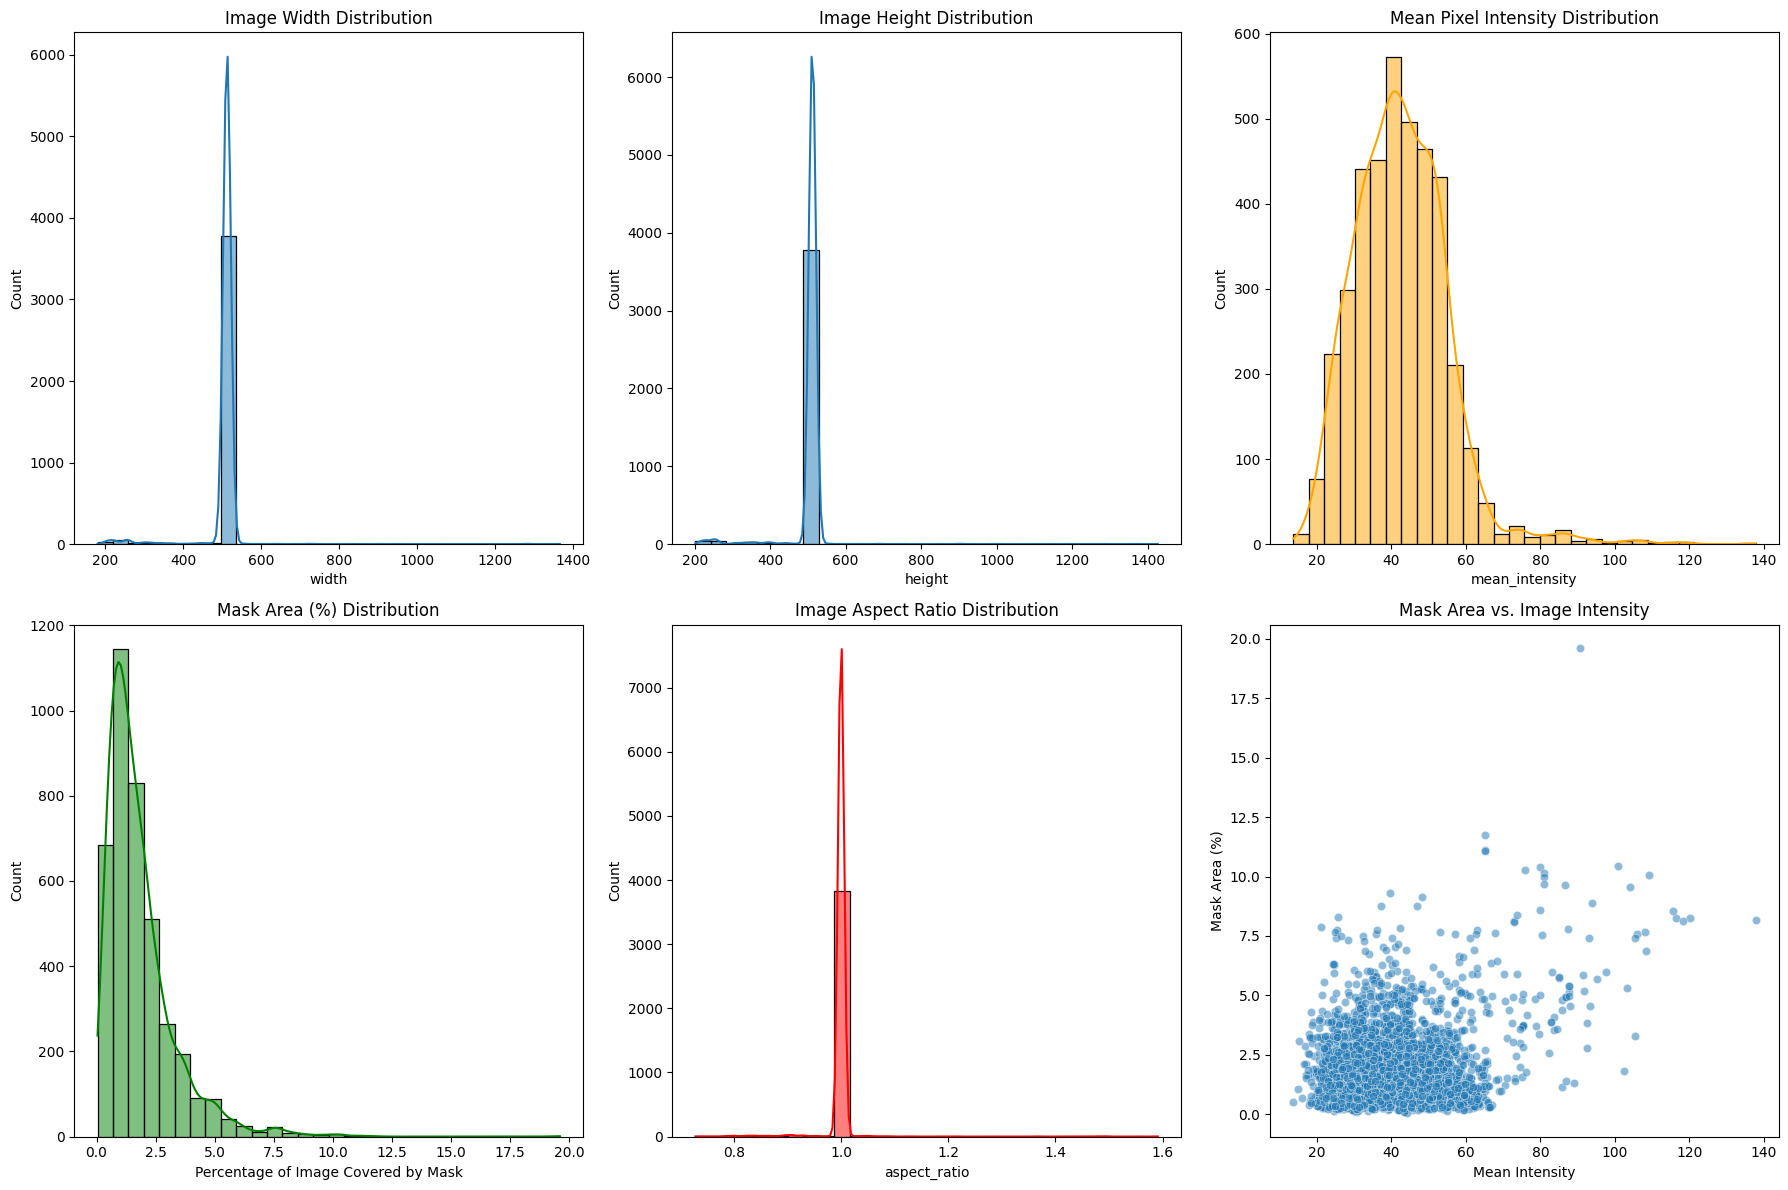

In [ ]:
def analyze_dataset_properties(image_dir, mask_dir):
    """
    Analyzes and plots distributions of image dimensions, intensity, and mask area.
    """
    properties = []
    image_files = os.listdir(image_dir)

    for fname in tqdm(image_files, desc="Analyzing dataset"):
        # Construct paths, assuming masks have same base name but .png extension
        base_name, _ = os.path.splitext(fname)
        img_path = os.path.join(image_dir, fname)
        mask_path = os.path.join(mask_dir, base_name + ".png")


        with Image.open(img_path) as img:
            width, height = img.size
            mean_intensity = np.array(img.convert("L")).mean()

        with Image.open(mask_path) as mask:
            mask_np = np.array(mask.convert("L"))
            # Calculate the percentage of the image covered by the mask
            mask_area_percent = (mask_np > 0).sum() / (width * height) * 100

        properties.append({
            "filename": fname,
            "width": width,
            "height": height,
            "aspect_ratio": width / height,
            "mean_intensity": mean_intensity,
            "mask_area_percent": mask_area_percent
        })

    df = pd.DataFrame(properties)

    # --- Plotting ---
    plt.figure(figsize=(18, 12))

    # Image Dimensions
    plt.subplot(2, 3, 1)
    sns.histplot(df['width'], kde=True, bins=30)
    plt.title('Image Width Distribution')

    plt.subplot(2, 3, 2)
    sns.histplot(df['height'], kde=True, bins=30)
    plt.title('Image Height Distribution')

    # Mean Intensity
    plt.subplot(2, 3, 3)
    sns.histplot(df['mean_intensity'], kde=True, bins=30, color='orange')
    plt.title('Mean Pixel Intensity Distribution')

    # Mask Area Percentage
    plt.subplot(2, 3, 4)
    sns.histplot(df['mask_area_percent'], kde=True, bins=30, color='green')
    plt.title('Mask Area (%) Distribution')
    plt.xlabel('Percentage of Image Covered by Mask')

    # Aspect Ratio
    plt.subplot(2, 3, 5)
    sns.histplot(df['aspect_ratio'], kde=True, bins=30, color='red')
    plt.title('Image Aspect Ratio Distribution')

    # Scatter plot of mask area vs intensity
    plt.subplot(2, 3, 6)
    sns.scatterplot(x='mean_intensity', y='mask_area_percent', data=df, alpha=0.5)
    plt.title('Mask Area vs. Image Intensity')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Mask Area (%)')

    plt.tight_layout()
    plt.show()

    return df

if not show:
  show = True
  # --- Example Usage ---
  if os.path.exists(train_image_dir) and os.path.exists(train_mask_dir):
      properties_df = analyze_dataset_properties(train_image_dir, train_mask_dir)
      # print(properties_df.describe()) # For a statistical summary
  else:
      print("Training directories not found.")

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 16 # Lower if you run out of memory
NUM_EPOCHS = 1 # Increase for better results
IMG_HEIGHT = 256
IMG_WIDTH = 256


--- Visualizing the effect of contrast enhancement ---


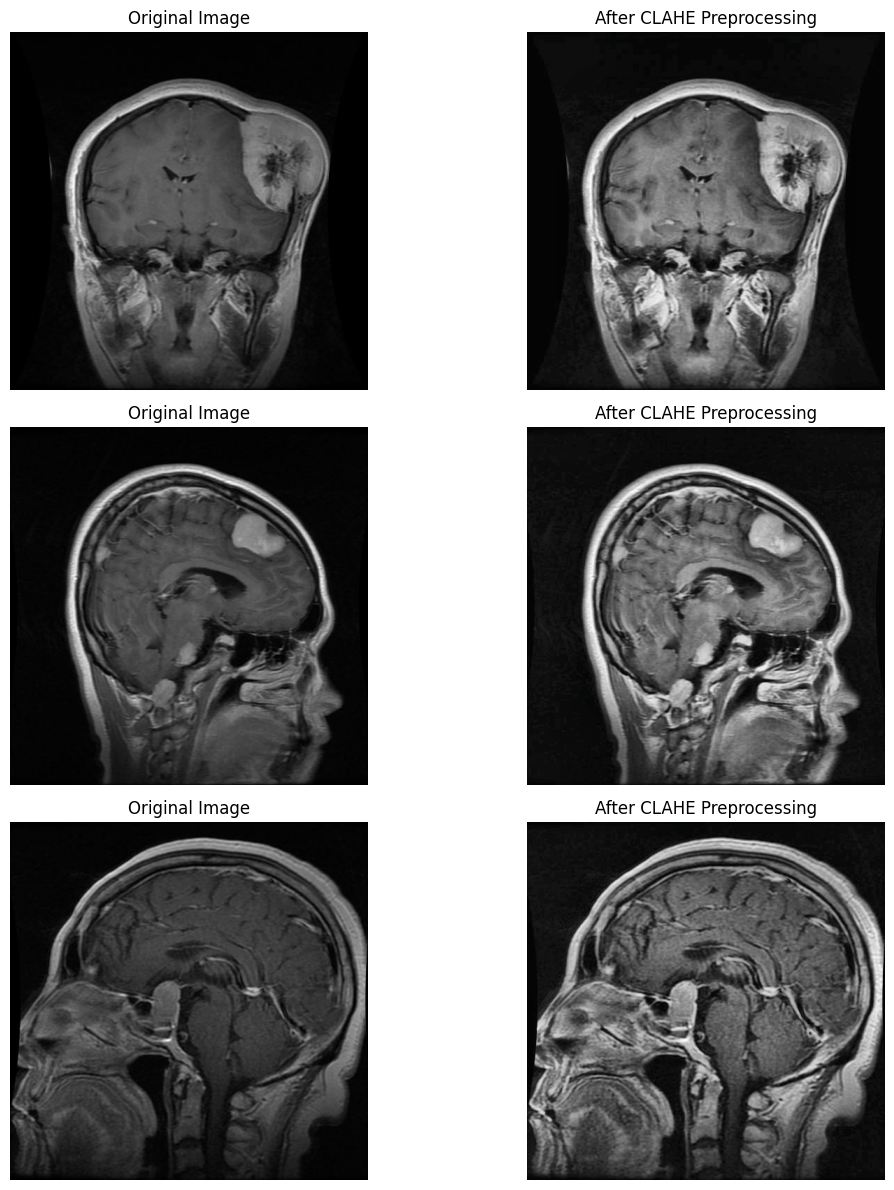


--- Data pipeline is ready! ---
Chosen Input Size: 256x256
Preprocessing includes CLAHE for contrast enhancement.
The plan is to use Dice Loss for training.


In [ ]:
def visualize_preprocessing_effect(image_dir, num_samples=3):
    """
    Visualizes the effect of CLAHE on the dark images.
    """
    image_files = sorted(os.listdir(image_dir))
    sample_indices = random.sample(range(len(image_files)), min(num_samples, len(image_files)))

    plt.figure(figsize=(12, 4 * num_samples))
    for i, index in enumerate(sample_indices):
        img_path = os.path.join(image_dir, image_files[index])
        # Read with OpenCV as albumentations works well with it
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        # Convert to LAB color space, apply CLAHE to L channel, and convert back
        lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab_image)
        l_clahe = clahe.apply(l)
        lab_clahe_image = cv2.merge((l_clahe, a, b))
        processed_image = cv2.cvtColor(lab_clahe_image, cv2.COLOR_LAB2RGB)

        # Display Original
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        # Display Processed
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(processed_image)
        plt.title("After CLAHE Preprocessing")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

print("--- Visualizing the effect of contrast enhancement ---")
if os.path.exists(train_image_dir):
    visualize_preprocessing_effect(train_image_dir)
else:
    print(f"Directory not found: {train_image_dir}")


# --- Updated Dataset Class with Albumentations ---

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", ".png")) # Corrected mask file extension

        # Reading with OpenCV is standard for albumentations
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask > 0] = 1.0 # Ensure mask is binary (0.0 or 1.0)

        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        # For demonstration, generate a random class label
        class_label = torch.randint(0, 2, (1,)).item()

        return image, mask.unsqueeze(0), torch.tensor(class_label, dtype=torch.long)


# --- Define Transformations with CLAHE ---

# These transformations will be applied during training
train_transform = A.Compose(
    [
        # 1. Resize to our chosen input size
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),

        # 2. Apply CLAHE to fix the low contrast
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),

        # 3. Add other augmentations to make the model robust
        A.Rotate(limit=35, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        # 4. Normalize and convert to PyTorch Tensor
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0, # Important since we read with OpenCV
        ),
        ToTensorV2(),
    ]
)

# For validation/testing, we only resize, apply CLAHE, and normalize
val_transform = A.Compose(
    [
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

print("\n--- Data pipeline is ready! ---")
print(f"Chosen Input Size: {IMG_WIDTH}x{IMG_HEIGHT}")
print("Preprocessing includes CLAHE for contrast enhancement.")

In [ ]:
# Helper module: A block of two 3x3 convolutions
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# The main U-Net Architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder Part (Downsampling)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder Part (Upsampling)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottleneck (the connection between encoder and decoder)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # Final convolution to produce the segmentation map
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        # We will extract this feature map for the classifier
        encoder_output = x
        skip_connections = skip_connections[::-1]

        # Decoder path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # In case of shape mismatch due to pooling
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        segmentation_output = self.final_conv(x)
        return segmentation_output, encoder_output

# Wrapper model that combines U-Net and a Classifier Head
class UNetWithClassifier(nn.Module):
    def __init__(self, in_channels=3, seg_out_channels=1, num_classes=2):
        super(UNetWithClassifier, self).__init__()
        self.unet = UNet(in_channels, seg_out_channels)

        # Classifier Head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # Global Average Pooling
            nn.Flatten(),
            nn.Linear(1024, 512),         # 1024 is the output of the U-Net bottleneck
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        segmentation_output, encoder_output = self.unet(x)
        classification_output = self.classifier(encoder_output)
        return segmentation_output, classification_output

print("--- Models are defined ---")
# Test if the model works
test_model = UNetWithClassifier().to(DEVICE)
test_input = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH).to(DEVICE)
seg_out, class_out = test_model(test_input)
print(f"Test Segmentation Output Shape: {seg_out.shape}")
print(f"Test Classification Output Shape: {class_out.shape}")

--- Models are defined ---
Test Segmentation Output Shape: torch.Size([1, 1, 256, 256])
Test Classification Output Shape: torch.Size([1, 2])


In [ ]:
# --- Loss Functions ---
# For segmentation, Dice Loss is a great choice for imbalanced pixels
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs) # Apply sigmoid to get probabilities
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice

# For classification, CrossEntropyLoss is standard
classification_loss_fn = nn.CrossEntropyLoss()
segmentation_loss_fn = DiceLoss()


# --- Dataloaders ---
def get_loaders(image_dir, mask_dir, batch_size, train_transform, val_transform, val_split=0.1, num_workers=2): # Changed default to 2
    full_dataset = SegmentationDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
        transform=None
    )

    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        # Use the passed num_workers parameter
        num_workers=num_workers,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        # Use the passed num_workers parameter
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_loader, val_loader

# Assuming train_image_dir and train_mask_dir are defined from your setup
train_loader, val_loader = get_loaders(
    train_image_dir,
    train_mask_dir,
    BATCH_SIZE,
    train_transform,
    val_transform
)

print("\n--- Loaders and Loss Functions are ready! ---")


--- Loaders and Loss Functions are ready! ---


In [ ]:
def check_accuracy(loader, model, seg_loss_fn, class_loss_fn, device="cuda"):
    """
    Checks a comprehensive set of metrics on the validation set.
    """
    model.eval() # Set model to evaluation mode

    # --- For Segmentation Metrics ---
    total_dice_numerator = 0
    total_dice_denominator = 0
    tp, fp, fn = 0, 0, 0 # True Positives, False Positives, False Negatives

    # --- For Classification Metrics & Losses ---
    all_labels = []
    all_preds = []
    all_probs = []
    total_val_loss = 0.0

    with torch.no_grad():
        for x, y_mask, y_class in loader:
            x = x.to(device)
            y_mask = y_mask.float().to(device)
            y_class = y_class.to(device)

            seg_preds, class_preds = model(x)

            # --- Calculate Losses ---
            seg_loss = seg_loss_fn(seg_preds, y_mask)
            class_loss = class_loss_fn(class_preds, y_class)
            total_val_loss += seg_loss.item() + class_loss.item()

            # --- Segmentation Metric Calculations ---
            seg_preds_prob = torch.sigmoid(seg_preds)
            seg_preds_binary = (seg_preds_prob > 0.5).float()

            # Dice Score components
            intersection = (seg_preds_binary * y_mask).sum()
            total_area = (seg_preds_binary + y_mask).sum()
            total_dice_numerator += (2 * intersection)
            total_dice_denominator += total_area

            # Precision, Recall, F1 components (pixel-level)
            tp += (seg_preds_binary * y_mask).sum().item()
            fp += ((1 - y_mask) * seg_preds_binary).sum().item()
            fn += (y_mask * (1 - seg_preds_binary)).sum().item()

            # --- Classification Metric Collections ---
            class_probs = torch.softmax(class_preds, dim=1)
            final_preds = class_preds.argmax(dim=1)

            all_labels.extend(y_class.cpu().numpy())
            all_preds.extend(final_preds.cpu().numpy())
            all_probs.extend(class_probs[:, 1].cpu().numpy()) # Probability of the positive class (class 1)

    # --- Final Metric Calculations ---

    # Segmentation
    final_dice_score = (total_dice_numerator / (total_dice_denominator + 1e-8)).item()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Losses
    avg_val_loss = total_val_loss / len(loader)

    # Classification accuracy (from collected preds/labels)
    val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100

    print(f"Validation Dice: {final_dice_score:.4f} | F1: {f1_score:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}% | Validation Loss: {avg_val_loss:.4f}")

    model.train() # Set model back to training mode

    return {
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy,
        "dice": final_dice_score,
        "f1": f1_score,
        "precision": precision,
        "recall": recall,
        "labels": all_labels,
        "predictions": all_preds,
        "probabilities": all_probs,
    }
def train_fn(loader, model, optimizer, seg_loss_fn, class_loss_fn):
    loop = tqdm(loader)
    total_train_loss = 0.0

    for batch_idx, (data, targets_mask, targets_class) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets_mask = targets_mask.float().to(device=DEVICE)
        targets_class = targets_class.to(device=DEVICE)

        # Forward
        seg_predictions, class_predictions = model(data)
        seg_loss = seg_loss_fn(seg_predictions, targets_mask)
        class_loss = class_loss_fn(class_predictions, targets_class)
        total_loss = seg_loss + 0.5 * class_loss

        total_train_loss += total_loss.item()

        # Backward
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loop.set_postfix(loss=total_loss.item())

    return total_train_loss / len(loader) # Return average training loss

In [ ]:
def plot_metrics(history, val_results):
    """
    Plots all the required metrics and curves.
    """
    # --- Plot 1: Loss and Accuracy Curves ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Loss Curve
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy Curve
    ax2.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
    ax2.set_title('Validation Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

    # --- Plot 2: Confusion Matrix and ROC Curve ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Confusion Matrix
    cm = confusion_matrix(val_results['labels'], val_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Classification Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # ROC Curve
    fpr, tpr, _ = roc_curve(val_results['labels'], val_results['probabilities'])
    roc_auc = auc(fpr, tpr)

    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")
    ax2.grid(True)

    plt.show()


In [ ]:
# --- Main Function to run everything ---
def main():

    model = UNetWithClassifier(in_channels=3, seg_out_channels=1, num_classes=2).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        train_image_dir,
        train_mask_dir,
        BATCH_SIZE,
        train_transform,
        val_transform
    )
    # --- History tracking ---
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": [],
    }

    best_dice_score = -1.0
     # --- LOAD CHECKPOINT ---
    # Load previous state if it exists. This will set the starting epoch and best score.
    start_epoch, best_dice_score = load_checkpoint(model, optimizer, filename=CHECKPOINT_PATH)

    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

        # Train and get average training loss
        avg_train_loss = train_fn(train_loader, model, optimizer, segmentation_loss_fn, classification_loss_fn)
        history["train_loss"].append(avg_train_loss)

        # Validate and get all validation metrics
        val_metrics = check_accuracy(val_loader, model, segmentation_loss_fn, classification_loss_fn, device=DEVICE)
        history["val_loss"].append(val_metrics["val_loss"])
        history["val_accuracy"].append(val_metrics["val_accuracy"])

        # Logic to save the best model (based on Dice score)
        current_dice_score = val_metrics["dice"]

        # --- SAVE CHECKPOINT ---
        # Create a dictionary with the current state
        checkpoint_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_score': best_dice_score,
        }
        # Save the latest state at the end of every epoch
        save_checkpoint(checkpoint_state, filename=CHECKPOINT_PATH)

        if current_dice_score > best_dice_score:
            best_dice_score = current_dice_score
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"✅ New best model saved with Dice Score: {best_dice_score:.4f}")

    # --- After training is complete, load the best model and generate final plots ---
    print("\n--- Training Finished. Evaluating best model and plotting metrics. ---")
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))

    # Get final validation results from the BEST saved model
    final_val_results = check_accuracy(val_loader, model, segmentation_loss_fn, classification_loss_fn, device=DEVICE)

    # Combine history and final results into a single dictionary
    results_to_save = {
        'history': history,
        'final_results': final_val_results
    }

    # Save this dictionary to the file
    torch.save(results_to_save, RESULTS_SAVE_PATH)
    print(f"📈 Training history and final metrics saved to {RESULTS_SAVE_PATH}")


# Remember to define all necessary variables and then call:
if __name__ == "__main__":
    main()

=> Loading checkpoint
=> Loaded checkpoint. Resuming from epoch 10

--- Epoch 1/1 ---


100%|██████████| 222/222 [02:52<00:00,  1.29it/s, loss=0.424]


Validation Dice: 0.9241 | F1: 0.9241 | Precision: 0.9425 | Recall: 0.9065
Validation Accuracy: 52.16% | Validation Loss: 0.7695
=> Saving checkpoint
✅ New best model saved with Dice Score: 0.9241

--- Training Finished. Evaluating best model and plotting metrics. ---
Validation Dice: 0.9241 | F1: 0.9241 | Precision: 0.9425 | Recall: 0.9065
Validation Accuracy: 53.94% | Validation Loss: 0.7694
📈 Training history and final metrics saved to /content/drive/MyDrive/BRISC2025_Project/training_results.pth


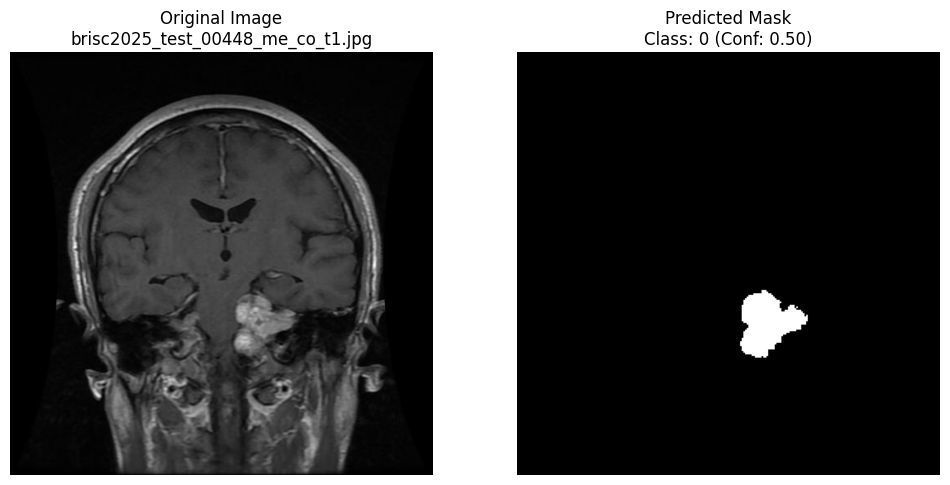

In [ ]:
def predict_and_visualize(model, image_dir, transform, device="cuda"):
    """
    Takes an image directory, selects a random image, runs inference, and displays the results.
    """
    model.eval()

    # Select a random image from the directory
    image_files = os.listdir(image_dir)
    if not image_files:
        print("No images found in the directory.")
        return
    random_image_file = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image_file)

    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a dummy mask for the transform function, as it expects both image and mask
    dummy_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.uint8)
    augmentations = transform(image=image_rgb, mask=dummy_mask)
    input_tensor = augmentations["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        seg_pred, class_pred = model(input_tensor)

        # Process segmentation output
        seg_pred = torch.sigmoid(seg_pred)
        seg_pred_binary = (seg_pred > 0.5).float().cpu().squeeze(0).squeeze(0).numpy()

        # Process classification output
        class_prob = torch.softmax(class_pred, dim=1)
        top_prob, top_class_idx = class_prob.topk(1, dim=1)
        predicted_class = top_class_idx.item()
        prediction_confidence = top_prob.item()

    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(f"Original Image\n{random_image_file}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(seg_pred_binary, cmap='gray')
    plt.title(f"Predicted Mask\nClass: {predicted_class} (Conf: {prediction_confidence:.2f})")
    plt.axis("off")
    plt.show()


model_for_inference = UNetWithClassifier().to(DEVICE)
model_for_inference.load_state_dict(torch.load(MODEL_SAVE_PATH))
predict_and_visualize(model_for_inference, test_image_dir, val_transform, device=DEVICE)

Loading results from /content/drive/MyDrive/BRISC2025_Project/training_results.pth...
Generating plots...


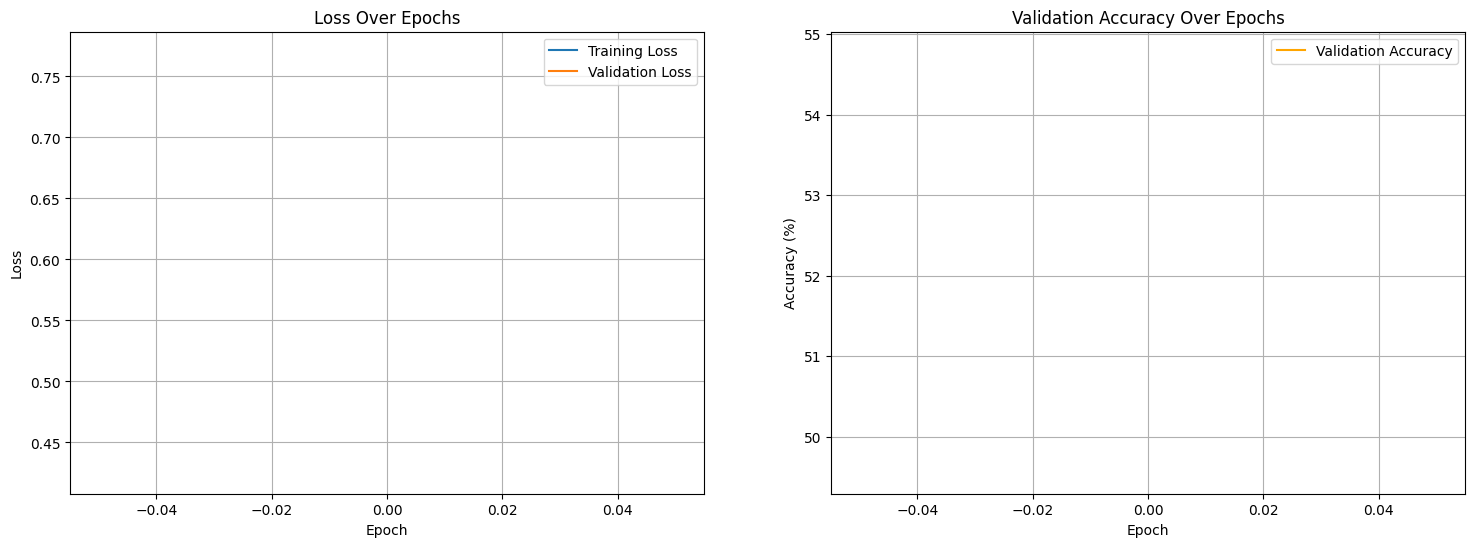

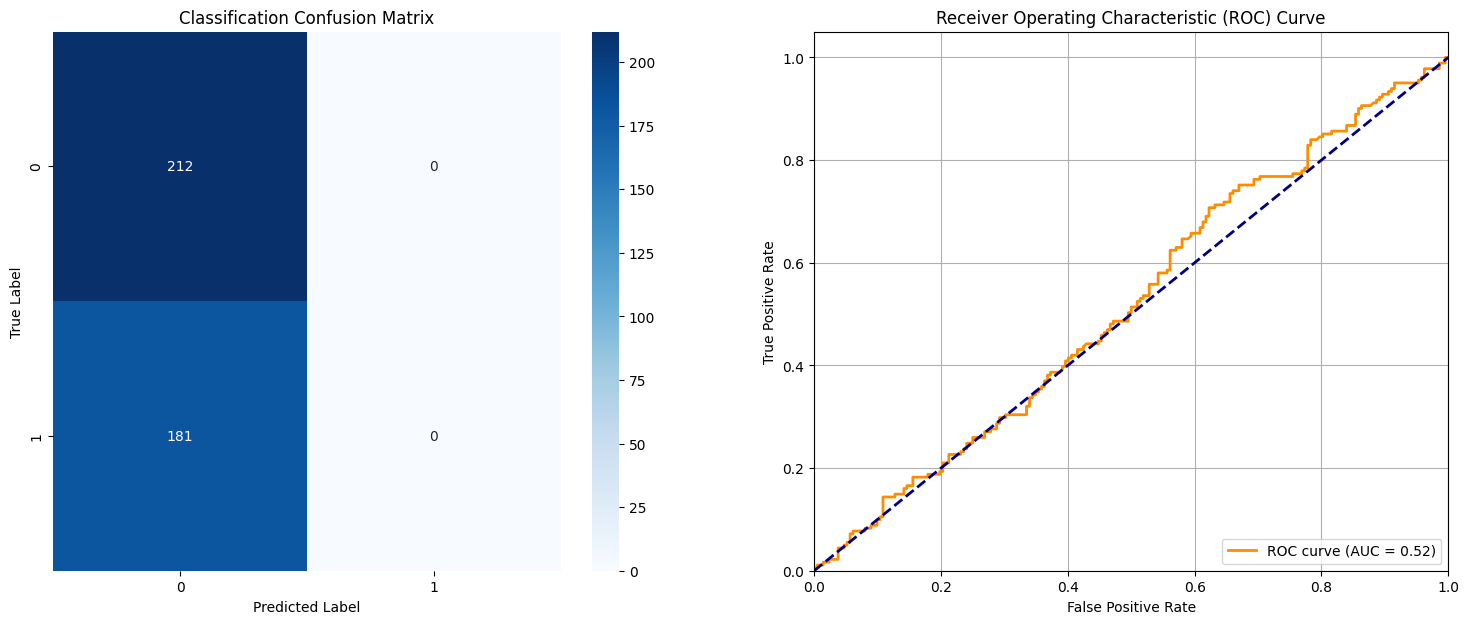

In [ ]:
# 1. Define the path to your saved results
RESULTS_SAVE_PATH = "/content/drive/MyDrive/BRISC2025_Project/training_results.pth"

# 2. Load the saved results dictionary
print(f"Loading results from {RESULTS_SAVE_PATH}...")
# Add weights_only=False to allow loading the file
saved_results = torch.load(RESULTS_SAVE_PATH, weights_only=False)

# 3. Extract the history and final metrics
training_history = saved_results['history']
final_metrics = saved_results['final_results']

# 4. Call the plotting function
print("Generating plots...")
plot_metrics(training_history, final_metrics)

In [ ]:
# F1, precision, recall
# confusion matrix
# ROC curve
# loss, accuracy curve generate (training, loss)
# attention mechanism and transformer mecha